In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import random
from Anisotropic import anisodiff
from sklearn.model_selection import train_test_split
from UNet import UNet
import tensorflow as tf

In [2]:
def read_images(dir):
    images = []
    for filename in os.listdir(dir):
        img = cv2.imread(os.path.join(dir, filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
def images_to_gray_scale(images):
    gray_images = []
    for img in images:
        gray_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return gray_images

In [4]:
def show_image(image, title=''):
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()

In [5]:
# images = read_images('BSDS500')
# gray_images = images_to_gray_scale(images)

In [6]:
def anisotropic_filter(images):
    filtered = []
    for img in images:
        img = anisodiff(img, niter=50, kappa=20, gamma=0.2, step=(1., 1.), option=1, ploton=False)
        filtered.append(img)

    return filtered

In [7]:
# filtered = anisotropic_filter(gray_images)

In [8]:
# filtered_numpy = np.array(filtered, dtype=object)
# np.save('filtered.npy', filtered_numpy)

In [9]:
# gray_images_numpy = np.array(gray_images, dtype=object)
# np.save('gray_images.npy', gray_images_numpy)

In [10]:
gray_images = np.load('gray_images.npy', allow_pickle=True)

In [11]:
filtered = np.load('filtered.npy', allow_pickle=True)

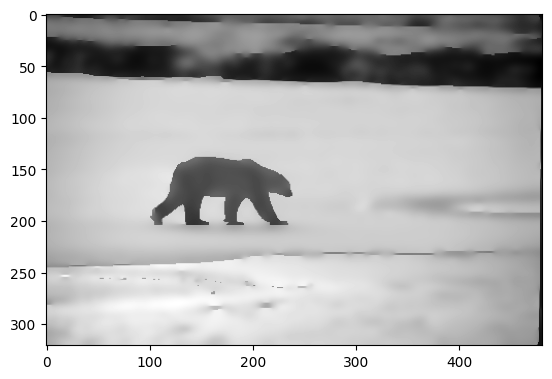

In [12]:
show_image(filtered[0])

In [13]:
def create_windows(original_image, filtered_image, window_size, n_windows):
    windows_X = []
    windows_y = []
    
    for _ in range(n_windows):
        
        width, height = original_image.shape
        x = random.randint(0, width - window_size)
        y = random.randint(0, height - window_size)
        porcion_original = original_image[x:x + window_size, y:y + window_size]
        porcion_filtrada = filtered_image[x:x + window_size, y:y + window_size]
        
        windows_X.append(porcion_original)
        windows_y.append(porcion_filtrada)
    
        
    return windows_X, windows_y
    

In [14]:
def get_windows(original_images, filtered_images, total_windows, window_size):
    windows_per_image = int(total_windows // len(original_images))
    windows_X = []
    windows_y = []
    for i in range(original_images.shape[0]):
        original_image = original_images[i]
        filtered_image = filtered_images[i]
        original_windows, filtered_windows = create_windows(original_image, filtered_image, window_size, windows_per_image)
        windows_X += original_windows
        windows_y += filtered_windows
    windows_X = np.array(windows_X)
    windows_y = np.array(windows_y)
    return windows_X, windows_y

In [15]:
def get_dataset(X, y, batch_size=32):
    # Convertir los arrays en un Dataset de TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    
    # Shuffling y batching del dataset
    dataset = dataset.shuffle(buffer_size=len(X))  # Asegúrate de mezclar bien los datos
    dataset = dataset.batch(batch_size)  # Batching
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Optimización para preparar datos mientras entrena
    
    return dataset


In [16]:
X, y = get_windows(gray_images, filtered, 50000, 32)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [19]:
train_dataset = get_dataset(X_train, y_train, batch_size=32)
val_dataset = get_dataset(X_val, y_val, batch_size=32)
test_dataset = get_dataset(X_test, y_test, batch_size=32)

In [20]:
input_size = (32, 32, 1)

In [21]:
model = UNet(input_size, n_classes=1)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# model.fit(train_dataset, validation_data=val_dataset, epochs=10)

In [25]:
model.load_weights('UNet_model_weights.h5')

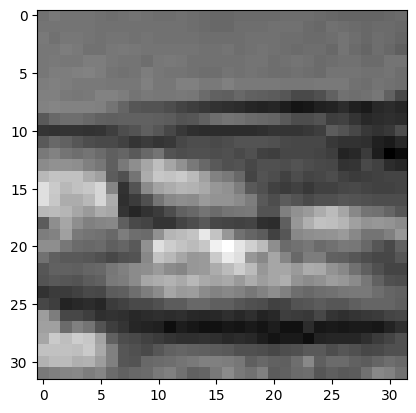

In [26]:
prueba = X_test[20][:32, :32].reshape(1, 32, 32, 1)
res = model.predict(prueba, verbose=0)
show_image(X_test[20][:32, :32])

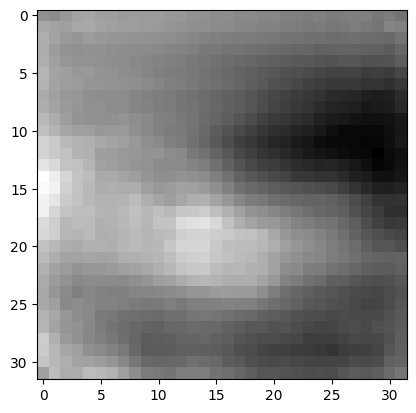

In [27]:
show_image(res[0]) 

In [28]:
def cut_image(overlap, image, window_size):
    height, width = image.shape
    x = 0
    windows = []
    while x + window_size <= height:
        y = 0
        while y + window_size <= width:
            windows.append(image[x:x + window_size, y:y + window_size])
            y += window_size - overlap
        if y < width:
            windows.append(image[x:x + window_size, width - window_size:width])
        x += window_size - overlap
    if x < height:
        y = 0
        while y + window_size <= width:
            windows.append(image[height - window_size:height, y:y + window_size])
            y += window_size - overlap
        if y < width:
            windows.append(image[height - window_size:height, width - window_size:width])
    return windows


In [29]:
def join_image(windows, image_shape, window_size, overlap):
    height, width = image_shape
    restored_image = np.zeros(image_shape)
    contributions = np.zeros(image_shape)

    index = 0
    x = 0
    while x + window_size <= height:
        y = 0
        while y + window_size <= width:
            restored_image[x:x + window_size, y:y + window_size] += windows[index]
            contributions[x:x + window_size, y:y + window_size] += 1
            index += 1
            y += window_size - overlap
        if y < width:
            restored_image[x:x + window_size, width - window_size:width] += windows[index]
            contributions[x:x + window_size, width - window_size:width] += 1
            index += 1
        x += window_size - overlap
    if x < height:
        y = 0
        while y + window_size <= width:
            restored_image[height - window_size:height, y:y + window_size] += windows[index]
            contributions[height - window_size:height, y:y + window_size] += 1
            index += 1
            y += window_size - overlap
        if y < width:
            restored_image[height - window_size:height, width - window_size:width] += windows[index]
            contributions[height - window_size:height, width - window_size:width] += 1
            index += 1

    contributions[contributions == 0] = 1
    restored_image /= contributions
    return restored_image

In [30]:
def UNet_filter_inference(image, window_size, overlap, model):
    image_cut = cut_image(overlap, image, window_size)
    image_cut = np.array(image_cut)
    image_cut = image_cut.reshape(image_cut.shape[0], window_size, window_size, 1)

    res = model.predict(image_cut, verbose=0)
    res = res.reshape(res.shape[0], window_size, window_size)

    restored_image = join_image(res, image.shape, window_size, overlap)
    return restored_image

In [31]:
idx = 50
original_image = gray_images[idx]
filtered_image = filtered[idx]

restored_image = UNet_filter_inference(original_image, 32, 16, model)

In [32]:
def L2_error(original, restored):
    return np.sqrt(np.sum((original - restored) ** 2))

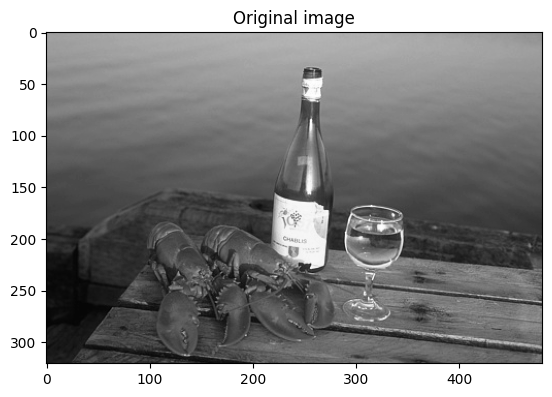

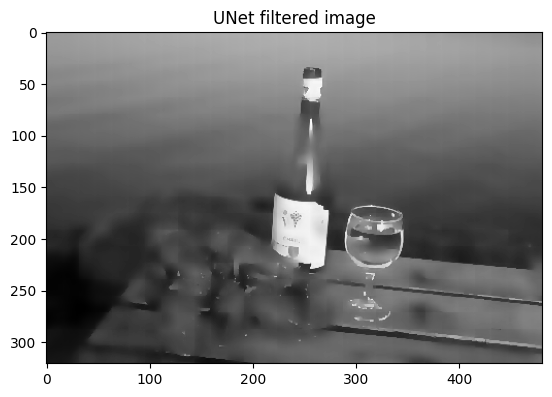

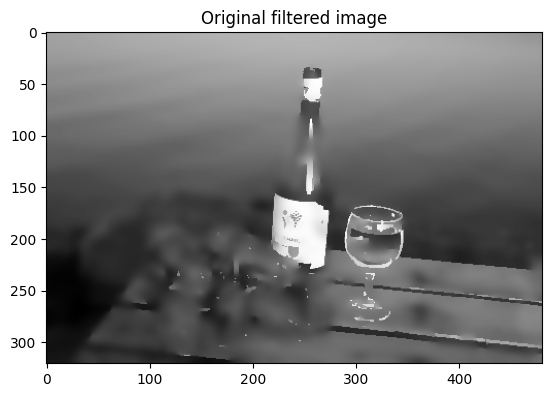

In [33]:
show_image(original_image, 'Original image')
show_image(restored_image, 'UNet filtered image')
show_image(filtered_image, 'Original filtered image')

In [34]:
error = L2_error(filtered_image, restored_image)
print('L2 error: ', error)

L2 error:  988.1801139507138
